# Data Downtime Challenge | Exercise 1

## 0. Setup

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [5]:
from ex1_utils import all_days, show_reports

In [6]:
import sqlite3

conn = sqlite3.connect('Ex1.db')
c = conn.cursor()

## 1. Introduction

Welcome to the Data Downtime Challenge! In this exercise, we'll learn Data Observability through practice on some sample datasets. Each subproblem will ask you to craft some `SQL` queries that help us learn about the state of our tables and identify Data Downtime issues.

For these exercises, we'll be using mock astronomical data to identify habitable planets.

![SegmentLocal](/tree/assets/planets.gif "segment")

The `Ex1.db` database contains a single table, `EXOPLANETS`, which has information on nearly 2000 exoplanets across the Milky Way Galaxy.

In [ ]:
c.execute("PRAGMA table_info(EXOPLANETS);")
c.fetchall()

A database entry in `EXOPLANETS` contains the following info:

0. `_id`: A UUID corresponding to the planet.
1. `distance`: Distance from Earth, in lightyears.
2. `g`: Surface gravity as a multiple of $g$, the gravitational force constant.
3. `orbital_period`: Length of a single orbital cycle in days.
4. `avg_temp`: Average surface temperature in degrees Kelvin.
5. `date_added`: The date our system discovered the planet and added it automatically to our databases.

Note that one or more of `distance`, `g`, `orbital_period`, and `avg_temp` may be `NULL` for a given planet as a result of missing or erroneous data.

In [ ]:
pd.read_sql_query("SELECT * FROM EXOPLANETS LIMIT 10", conn)

## 2. Exercise: Visualizing Freshness

Grouping by the `DATE_ADDED` column can give us insight into how `EXOPLANETS` updates daily. For example, we can query for the number of new IDs added per day:

In [7]:
SQL = """
SELECT
    DATE_ADDED,
    COUNT(*) AS ROWS_ADDED
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

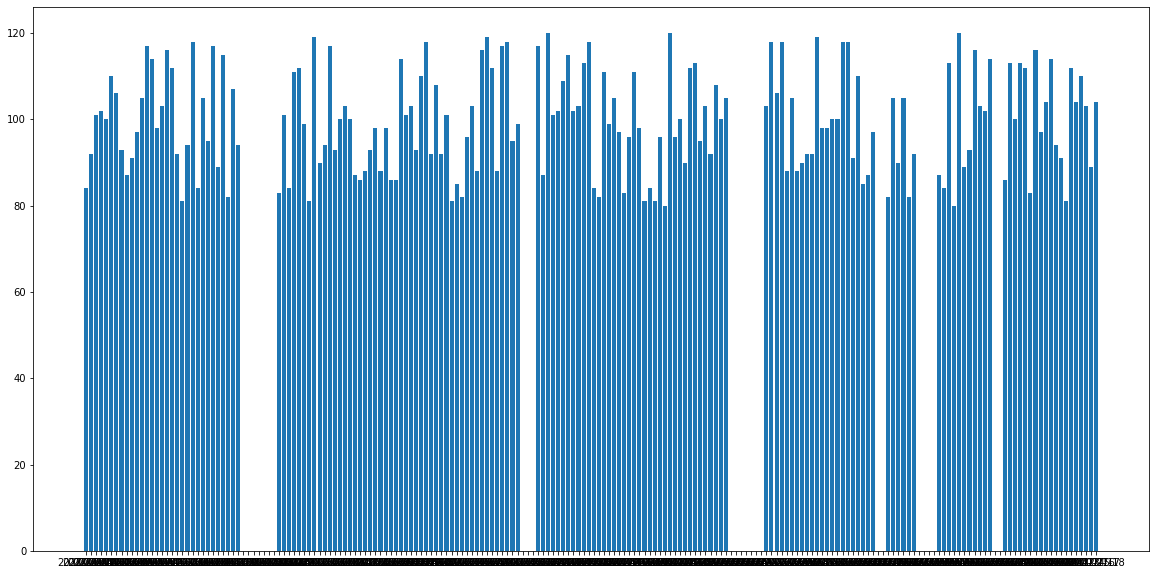

In [8]:
rows_added = pd.read_sql_query(SQL, conn)
rows_added = rows_added \
    .rename(columns={clmn: clmn.lower() for clmn in rows_added.columns})
rows_added = rows_added.set_index("date_added")
rows_added = rows_added.reindex(all_days)
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=rows_added["rows_added"])
plt.show()

It looks like `EXOPLANETS` typically updates with around 100 new entries each day. Something looks off in a few places, though. We have what we'd call a **freshness** incident -- on a couple of occasions, the table doesn't update at all for a 3 or more days. It has "stale" (3+ day old) data.

Try writing some `SQL` code that returns timestamps for when freshness incidents occur. Feel free to use the query above as a starting point.

- *Hint 1*: The `LAG` window function should help in comparing two subsequent rows in a query.
- *Hint 2*: `SQLite` uses `JULIANDAY()` to cast an object to a date.
- *Hint 3*: An example solution is given in `exercise_1_soln.ipynb` in this same directory, if needed for comparison.

In [ ]:
# YOUR CODE HERE
SQL = """

"""
# END YOUR CODE

In [ ]:
freshness_anoms = pd.read_sql_query(SQL, conn)
freshness_anoms = freshness_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in freshness_anoms.columns})
freshness_anoms

The `show_reports` function from `utils` will help us visualize our results.

In [ ]:
show_reports(rows_added, freshness_anoms["date_added"], "rows_added")

## 3. Exercise: Null Rates

We can also look at the rate of new `NULL` entries for different columns on a daily basis:

In [ ]:
SQL = """
SELECT
    DATE_ADDED,
    CAST(SUM(CASE WHEN DISTANCE IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS DISTANCE_NULL_RATE,
    CAST(SUM(CASE WHEN G IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS G_NULL_RATE,
    CAST(SUM(CASE WHEN ORBITAL_PERIOD IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ORBITAL_PERIOD_NULL_RATE,
    CAST(SUM(CASE WHEN AVG_TEMP IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS AVG_TEMP_NULL_RATE    
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

In [ ]:
null_rates = pd.read_sql_query(SQL, conn)
null_rates = null_rates \
    .rename(columns={clmn: clmn.lower() for clmn in null_rates.columns})
null_rates = null_rates.set_index("date_added")
null_rates = null_rates.reindex(all_days)

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["distance_null_rate"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["g_null_rate"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["orbital_period_null_rate"])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["avg_temp_null_rate"])
plt.show()

Some of the fields in the table show "spikes" in the rate of null values at certain times. Try to write a simple `SQL` query to identify timestamps with unusually high null rates. Again, feel free to use the query above as a starting point.

- *Hint 1*: It may help to introduce a column that identifies which field (or fields) have the anomalous null rate for a given timestamp.
- *Hint 2*: Once again, a sample solution is available in `ex1_soln.ipynb`, if needed.

In [ ]:
# YOUR CODE HERE
SQL = """

"""
# END YOUR CODE

In [ ]:
null_rate_anoms = pd.read_sql_query(SQL, conn)
null_rate_anoms = null_rate_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in null_rate_anoms.columns})
null_rate_anoms

Once again, we'll use the `show_reports` function to visualize the results of our query. Feel free to continue running the above and below cells until you're happy with the reports!

In [ ]:
show_reports(null_rates, null_rate_anoms["date_added"], "avg_temp_null_rate")

Great work! In the next exercise, we'll build off of these simpler reports to handle scenarios with multiple tables and lineage information.